## Remapping population density 
The aim of this little script is to remap all of the population density (from 1850 to 2014) and condense down into one file

In [1]:
%load_ext autoreload
%autoreload

import sys
sys.path.append('../')

import warnings
warnings.filterwarnings('ignore')

import os
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv

import iris
import iris.plot as iplt
from iris.experimental.equalise_cubes import equalise_attributes
import matplotlib.pyplot as plt
import numpy.ma as ma
%matplotlib inline
import cartopy.crs as ccrs
from   libs.plot_maps    import *
from netCDF4 import Dataset

In [28]:
dir = '../data/pop_dens/'

year = range(2001,2015)
files = []

for y in year:
    files.append('PD_HYDEv3.2_' + str(y) + '.nc')

### Load in a template cube
We're going to use the time structure from another variable and add in 12 months per year to turn it into monthly data

In [29]:
dir_temp = '../data/UKESM/retrieved_codes/2000-2014/'
tree_file = 'treeCover2001-2014.nc'
tree = iris.load_cube(dir_temp + tree_file)
template = tree.copy()
print(template)

# Load mask cube
mask_dir = '../data/n96_masked_data/'
file = 'no_t_n96_mask.nc'

mask = iris.load_cube(mask_dir + file)

m01s03i317 / (1)                    (time: 168; latitude: 144; longitude: 192)
     Dimension coordinates:
          time                           x              -               -
          latitude                       -              x               -
          longitude                      -              -               x
     Auxiliary coordinates:
          forecast_period                x              -               -
     Scalar coordinates:
          forecast_reference_time: 1850-01-01 00:00:00
          pseudo_level: 151, bound=(101, 202)
     Attributes:
          Conventions: CF-1.5
          STASH: m01s03i317
          source: Data from Met Office Unified Model
          um_version: 10.9
     Cell methods:
          mean: time (1 hour)
          sum: pseudo_level


### Regrid and load data
The cubes can't be merged in their current state, so we're going to write over the tree template (this works!)

In [31]:
j = 0
for y in year:
    pop = iris.load_cube(dir + 'PD_HYDEv3.2_' + str(y) + '.nc')
    for i in range(12):
        template.data[j,:,:] = pop.collapsed('time', iris.analysis.MEAN).data
        j += 1

In [32]:
print(template)

m01s03i317 / (1)                    (time: 168; latitude: 144; longitude: 192)
     Dimension coordinates:
          time                           x              -               -
          latitude                       -              x               -
          longitude                      -              -               x
     Auxiliary coordinates:
          forecast_period                x              -               -
     Scalar coordinates:
          forecast_reference_time: 1850-01-01 00:00:00
          pseudo_level: 151, bound=(101, 202)
     Attributes:
          Conventions: CF-1.5
          STASH: m01s03i317
          source: Data from Met Office Unified Model
          um_version: 10.9
     Cell methods:
          mean: time (1 hour)
          sum: pseudo_level


## Save output

In [34]:
out = '../data/UKESM/retrieved_codes/2000-2014/' + 'pop_dens' +str(year[0]) + '-' + str(year[len(year)-1]) + '.nc'
iris.save(template, out)

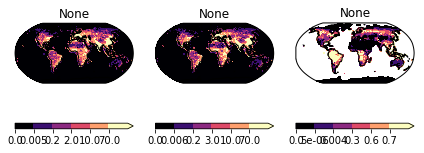

In [33]:
# plot_lonely_cube(pop[0], 1, 3, 2, cmap='magma', levels = None)
# plot_lonely_cube(template[2], 1, 3, 1, cmap='magma', levels = None)
# plot_lonely_cube(tree[2], 1, 3, 3, cmap='magma', levels = None)

plot_lonely_cube(template.collapsed(['time'], iris.analysis.MEAN), 1, 3, 1, cmap='magma', levels = None)
plot_lonely_cube(pop.collapsed(['time'], iris.analysis.MEAN), 1, 3, 2, cmap='magma', levels = None)
plot_lonely_cube(tree.collapsed(['time'], iris.analysis.MEAN), 1, 3, 3, cmap='magma', levels = None)

## Method B for merging the cube 
This way works, but it's probably in a weird time dimension and only accounts for yearly data

In [ ]:
dir = '../data/pop_dens/'

year = range(1851,2015)
files = []
aList = []
i = 0

# Load data and create a cube list (very inefficiently)
for y in year:
    files.append('PD_HYDEv3.2_' + str(y) + '.nc')
    dat = iris.load_cube(dir + files[i])
    
    # Regrid
    m_cube = cubes.regrid(mask, iris.analysis.Linear())
    
    # Dim coord
    coord = iris.coords.DimCoord(y, 'time')
    dat.remove_coord('time')
    dat.add_dim_coord(coord,0)
    
    # Aux coord
#     coord = iris.coords.AuxCoord(y, 'year')
#     dat.add_aux_coord(coord)
    
    aList.append(dat)
    i += 1

In [ ]:
### Load in data
#Merge all .nc files together. None of the files specify a time stamp,
#so I've removed the time coordinate, and added another one in which tells iris the year.
#It can then concatenate (still keeps the same number of dimensions) into one cube

dir = '../data/pop_dens/'

year = range(1851,2015)
files = []
aList = []
i = 0

# Load data and create a cube list (very inefficiently)
for y in year:
    files.append('PD_HYDEv3.2_' + str(y) + '.nc')
    dat = iris.load_cube(dir + files[i])
    
    # Dim coord
    coord = iris.coords.DimCoord(y, 'time')
    dat.remove_coord('time')
    dat.add_dim_coord(coord,0)
    
    # Aux coord
#     coord = iris.coords.AuxCoord(y, 'year')
#     dat.add_aux_coord(coord)
    
    aList.append(dat)
    i += 1

#print(cube_list[0])
print(dat.coord('time'))

# Merge cube list together 
cube_list = iris.cube.CubeList(aList)
# cubes = cube_list.merge_cube()
cubes = cube_list.concatenate_cube()
# test = cubes[0:2]
print(cubes)

# Load the mask

mask_dir = '../data/n96_masked_data/'
file = 'no_t_n96_mask.nc'

mask = iris.load_cube(mask_dir + file)

# Plot data to check if it's loaded in correctly

dat = cubes.collapsed('time', iris.analysis.MEAN)
dat.long_name = 'Population Density'
plot_lonely_cube(dat, cmap = 'magma', levels = None)

## Regrid
# Using the mask n96e from 'regrid_nc' notebook, we're going to regrid the data.
# The main difference is the labelling of the lat and lon - both the original and the masked
# grid have the same number of coordinates

m_cube = cubes.regrid(mask, iris.analysis.Linear())

out = '../data/UKESM/retrieved_codes/' + 'pop_dens_yearly' +str(year[0]) + '-' + str(year[len(year)-1]) + '.nc'
iris.save(m_cube, out)